# 1. Read Data

# 1.1 Education Status of Voters in 2023 Parliamentary General Elections

In [1]:
import os
import pandas as pd
import re
folder_path = ("data/raw/election/voters-age-sex-education/2023")
files = os.listdir(folder_path) 
files[:3] # check first 3 file names

['Adana.xlsx', 'Adıyaman.xlsx', 'Afyonkarahisar.xlsx']

Examine a sample file

In [2]:
file_name=files[0]
file_path = os.path.join(folder_path,file_name)
df_sub = pd.read_excel(file_path,skiprows=3)
df_sub.head()

,Adana,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Aladağ,NaN,Okuma yazma bilmeyen,Okuma yazma bilen fakat bir okul bitirmeyen,İlkokul,İlköğretim,Ortaokul veya dengi okul,Lise veya dengi okul,Yüksekokul veya fakülte,Yüksek lisans,Doktora,Bilinmeyen,Toplam
1,18-24,Erkek,-,1,1,-,92,557,132,-,-,10,793
2,NaN,Kadın,-,2,1,-,102,491,169,-,-,-,765
3,25-29,Erkek,-,1,2,-,92,226,220,12,-,2,555
4,NaN,Kadın,-,-,6,4,139,117,182,9,-,1,458


Let's get header columns

In [3]:
education_columns = df_sub.iloc[0,2:].tolist()
print(education_columns)

['Okuma yazma bilmeyen', 'Okuma yazma bilen fakat bir okul bitirmeyen', 'İlkokul', 'İlköğretim', 'Ortaokul veya dengi okul', 'Lise veya dengi okul', 'Yüksekokul veya fakülte', 'Yüksek lisans', 'Doktora', 'Bilinmeyen', 'Toplam']


* Heading is not important for now. Actual heading repeats at every 26th row along with the district name.
In other words; the first row includes  district name and education levels which will be actual headings.
* Next 24 rows (12x2) represent data for 12 age groups and 2 genders.
* 26th row represents total for that district
* After the first row, age groups follow. Rows with even indices in this column contain **NaN**s.
To fill NaN values we can use ffill method. 

Obtain age groups. There are 12 age groups.

In [4]:
age_groups = sorted(list({row for row in df_sub.iloc[:,0] if re.search(r'\d+', str(row))} )) 
print(age_groups)

['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75+']


**Step-1 Test:** Apply ffill on the first column and check again.

In [5]:
df_sub.iloc[:,0]=df_sub.iloc[:,0].ffill()
df_sub.head()

,Adana,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Aladağ,NaN,Okuma yazma bilmeyen,Okuma yazma bilen fakat bir okul bitirmeyen,İlkokul,İlköğretim,Ortaokul veya dengi okul,Lise veya dengi okul,Yüksekokul veya fakülte,Yüksek lisans,Doktora,Bilinmeyen,Toplam
1,18-24,Erkek,-,1,1,-,92,557,132,-,-,10,793
2,18-24,Kadın,-,2,1,-,102,491,169,-,-,-,765
3,25-29,Erkek,-,1,2,-,92,226,220,12,-,2,555
4,25-29,Kadın,-,-,6,4,139,117,182,9,-,1,458


Step-2 Test: Replace - symbol with zeros.

In [6]:
df_sub.replace('-', 0, inplace=True)
df_sub.head()

,Adana,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Aladağ,NaN,Okuma yazma bilmeyen,Okuma yazma bilen fakat bir okul bitirmeyen,İlkokul,İlköğretim,Ortaokul veya dengi okul,Lise veya dengi okul,Yüksekokul veya fakülte,Yüksek lisans,Doktora,Bilinmeyen,Toplam
1,18-24,Erkek,0,1,1,0,92,557,132,0,0,10,793
2,18-24,Kadın,0,2,1,0,102,491,169,0,0,0,765
3,25-29,Erkek,0,1,2,0,92,226,220,12,0,2,555
4,25-29,Kadın,0,0,6,4,139,117,182,9,0,1,458


In [7]:
def parse_filepath(filepath):
    match = re.match(r"([\wşŞçÇöÖüÜğĞıİ]+)", filepath)
    if match:
        return match.group(1)

## Data Preprocessing
Now we can apply the steps we tested above on all files and then merge them.
### Preprocess & Merge dataframs
* Preprocess files and obtain dataframe for each file
* Merge dataframes

#### 1. Read files as dataframes and gather in list.

In [8]:
import numpy as np
df_list = []
for file_name in files:    
    file_path = os.path.join(folder_path, file_name)
    df_sub = pd.read_excel(file_path, skiprows=3 ) # skip 3 empty rows. each df_sub represents a province
    df_sub.iloc[:,0]=df_sub.iloc[:,0].ffill() # step-1 fill NaN values for age-groups. This will fill using the previous row value.
    
    df_sub.columns = ["age","sex"] + education_columns # name columns
    df_sub["province"] = parse_filepath(file_name)  # get province name from filename.
    df_sub["district"] = np.nan # create a district column.We will skip the column that includes district name, below save district name in its own column of other rows
    df_sub.replace('-', 0, inplace=True) # step-2 # replace hyphen symbol with zeros.
    df_list.append(df_sub)

#### 2-Create and fill district column, remove "district" and "total" rows for each dataframe(df_sub) in the df_list

In [9]:
#A sample df_sub
df_sub.head(3)

,age,sex,Okuma yazma bilmeyen,Okuma yazma bilen fakat bir okul bitirmeyen,İlkokul,İlköğretim,Ortaokul veya dengi okul,Lise veya dengi okul,Yüksekokul veya fakülte,Yüksek lisans,Doktora,Bilinmeyen,Toplam,province,district
0,Beytüşşebap,NaN,Okuma yazma bilmeyen,Okuma yazma bilen fakat bir okul bitirmeyen,İlkokul,İlköğretim,Ortaokul veya dengi okul,Lise veya dengi okul,Yüksekokul veya fakülte,Yüksek lisans,Doktora,Bilinmeyen,Toplam,Şırnak,NaN
1,18-24,Erkek,3,8,25,4,382,762,107,0,0,22,1.313,Şırnak,NaN
2,18-24,Kadın,0,20,20,0,284,716,114,3,0,5,1.162,Şırnak,NaN


In [10]:
for i,df_sub in enumerate(df_list):
    df_sub.drop(columns=["Toplam"],inplace=True)
    district_name_rows_mask =df_sub.iloc[:,0].apply(lambda x: (x!="Toplam"and not bool(re.search(r'\d', x)) or x=="19 Mayıs"  ) )# in the age column there is a district name with digits
    df_sub.loc[district_name_rows_mask,"district"] = df_sub.loc[district_name_rows_mask,"age"] # Note the Age column still includes district names and "total" rows
    df_sub.loc[:,"district"] = df_sub.loc[:,"district"].ffill() # save districts in its own column
     # now we can get rid off district and total columns and replace the original df_sub with the new df_sub
    df_list[i] = df_sub.loc[df_sub.iloc[:,0].apply(lambda x: x!="19 Mayıs" and bool(re.search(r'\d', x)))].reset_index(drop=True)
    

C:\Users\Neo\AppData\Local\Temp\ipykernel_1188\326251083.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Aladağ' 'Ceyhan' 'Çukurova' 'Feke' 'İmamoğlu' 'Karaisalı' 'Karataş'
 'Kozan' 'Pozantı' 'Saimbeyli' 'Sarıçam' 'Seyhan' 'Tufanbeyli'
 'Yumurtalık' 'Yüreğir']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sub.loc[district_name_rows_mask,"district"] = df_sub.loc[district_name_rows_mask,"age"] # Note the Age column still includes district names and "total" rows
C:\Users\Neo\AppData\Local\Temp\ipykernel_1188\326251083.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Adıyaman Merkez' 'Besni' 'Çelikhan' 'Gerger' 'Gölbaşı' 'Kahta' 'Samsat'
 'Sincik' 'Tut']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sub.loc[district_nam

In [11]:
len(df_list) # There are 81 provinces

81

### Merge provinces

In [12]:
df_edu = pd.concat(df_list)
df_edu.head()

,age,sex,Okuma yazma bilmeyen,Okuma yazma bilen fakat bir okul bitirmeyen,İlkokul,İlköğretim,Ortaokul veya dengi okul,Lise veya dengi okul,Yüksekokul veya fakülte,Yüksek lisans,Doktora,Bilinmeyen,province,district
0,18-24,Erkek,0,1,1,0,92,557,132,0,0,10,Adana,Aladağ
1,18-24,Kadın,0,2,1,0,102,491,169,0,0,0,Adana,Aladağ
2,25-29,Erkek,0,1,2,0,92,226,220,12,0,2,Adana,Aladağ
3,25-29,Kadın,0,0,6,4,139,117,182,9,0,1,Adana,Aladağ
4,30-34,Erkek,0,0,1,50,62,207,148,22,0,1,Adana,Aladağ


#### Reorder dataframe as multi-index columns

In [13]:
df_edu = df_edu.set_index(["province","district","sex","age"]).unstack([2,3]).rename_axis(['education_level',"sex","age"], axis=1).reorder_levels(order=["sex",'age', "education_level"], axis=1)
#.loc[:,(slice(None),slice(None),"Doktora")].sum(axis=1)
df_edu.head()

sex                               Erkek                Kadın  \
age                               18-24                18-24   
education_level    Okuma yazma bilmeyen Okuma yazma bilmeyen   
province district                                              
Adana    Aladağ                       0                    0   
         Ceyhan                       2                    2   
         Feke                         0                    0   
         Karaisalı                    0                    0   
         Karataş                      0                    0   

sex                               Erkek                Kadın  \
age                               25-29                25-29   
education_level    Okuma yazma bilmeyen Okuma yazma bilmeyen   
province district                                              
Adana    Aladağ                       0                    0   
         Ceyhan                       8                   45   
         Feke                         0                    0   
         Karaisalı                    1                    1   
         Karataş                      2                    9   

sex                               Erkek                Kadın  \
age                               30-34                30-34   
education_level    Okuma yazma bilmeyen Okuma yazma bilmeyen   
province district                                              
Adana    Aladağ                       0                    1   
         Ceyhan                      12                  124   
         Feke                         1                    1   
         Karaisalı                    0                    2   
         Karataş                      2                   26   

sex                               Erkek                Kadın  \
age                               35-39                35-39   
education_level    Okuma yazma bilmeyen Okuma yazma bilmeyen   
province district                                              
Adana    Aladağ                       2                    3   
         Ceyhan                      20                  132   
         Feke                         5                    1   
         Karaisalı                    0                    3   
         Karataş                      1                   18   

sex                               Erkek                Kadın  ...      Erkek  \
age                               40-44                40-44  ...      55-59   
education_level    Okuma yazma bilmeyen Okuma yazma bilmeyen  ... Bilinmeyen   
province district                                             ...              
Adana    Aladağ                       1                    2  ...          0   
         Ceyhan                      22                  116  ...         37   
         Feke                         2                    3  ...         10   
         Karaisalı                    3                    5  ...          3   
         Karataş                     10                   21  ...         10   

sex                     Kadın      Erkek      Kadın      Erkek      Kadın  \
age                     55-59      60-64      60-64      65-69      65-69   
education_level    Bilinmeyen Bilinmeyen Bilinmeyen Bilinmeyen Bilinmeyen   
province district                                                           
Adana    Aladağ             1          2          2          0          2   
         Ceyhan            42         41         36         42         43   
         Feke               7         11          7          1          5   
         Karaisalı          1          3          1          2          1   
         Karataş            9         18          8         18          7   

sex                     Erkek      Kadın      Erkek      Kadın  
age                     70-74      70-74        75+        75+  
education_level    Bilinmeyen Bilinmeyen Bilinmeyen Bilinmeyen  
province district                                               
Adana    Aladağ  

In [15]:
df_edu =df_edu.astype(int)

## 1.2 Results of 2023 Parliamentary General Elections

In [13]:
folder_path = "data/2023-iibs3-parliamentary-general-elections"
files = os.listdir(folder_path)
df_list=[]
column_names = pd.read_excel(os.path.join(folder_path,files[0] ) ,skiprows=7).columns[6:].tolist()

for file_name in files:
    file_path = os.path.join(folder_path,file_name) 
    df_sub = pd.read_excel(file_path,skiprows=10)
    df_sub.drop(columns=df_sub.columns[0:2].tolist()+df_sub.columns[4:6].tolist(),inplace=True)
    df_sub.dropna(subset=df_sub.columns[0],inplace=True)
    df_sub.drop(columns=df_sub.columns[1],inplace=True)
    df_sub.columns=["district"] + column_names
    df_sub["province"] = parse_filepath(file_name)
    df_list.append(df_sub)

### Merge districts

In [14]:
df_election = pd.concat(df_list)
df_election.head()

,district,Sandık sayısı,Kayıtlı seçmen sayısı,Oy kullanan seçmen sayısı,Geçerli oy sayısı,MİLLET,HAK PAR,TKP,TKH,SOL PARTİ,...,İYİ PARTİ,AP,ZAFER PARTİSİ,SOSYALİST GÜÇ BİRLİĞİ İTTİFAKI,CUMHUR İTTİFAKI,EMEK VE ÖZGÜRLÜK İTTİFAKI,MİLLET İTTİFAKI,ATA İTTİFAKI,BĞMZ,province
0,Seyhan,1565,562326,489246,476233,407,266,488,120,1165,...,43124,0,8812,20,2540,172,2205,4,348,Adana
2,Ceyhan,357,112582,98825,95960,67,65,80,18,204,...,10513,0,1756,3,593,36,343,0,33,Adana
4,Feke,60,12788,11039,10590,17,33,17,9,4,...,1029,0,181,1,108,0,27,0,56,Adana
6,Karaisalı,84,17312,16011,15573,35,16,7,7,3,...,1724,0,301,2,162,1,55,0,9,Adana
8,Karataş,72,17032,15307,14995,7,5,16,6,7,...,1608,0,164,0,109,2,100,0,6,Adana


In [15]:
df_election.replace('-', 0, inplace=True)

# 2. PRE-PROCESSING

## 2.1 Pre-process **df_edu**

Convert df_edu to multiindex using two indices **province** and **district**.

Convert df_election to multiindex using two indices **province** and **district**.

In [86]:
df_edu

Bilinmeyen  Toplam  0.seviye  1.seviye  2.seviye
province district                                                       
Adana    Aladağ                 29   12330     24660      3297      1438
         Ceyhan                750     103     42118      2732      7402
         Feke                   94   12788     25576      2761      1280
         Karaisalı              46   14908     32220      3849      2070
         Karataş               209   14727     31759      4415      2012
...                            ...     ...       ...       ...       ...
Şırnak   Güçlükonak             72    6895     13790      1886      1089
         Silopi               1116    4430     43922      4778      4477
         Uludere              1446    8031     28203      4297      3193
         İdil                  611    6058     34525      6575      3680
         Şırnak Merkez         670    4707     35158      5101      4469

[973 rows x 5 columns]

In [16]:
df_edu = df_edu.set_index(["province","district"])
df_edu.head()

Age    Sex Okuma yazma bilmeyen  \
province district                                      
Adana    Aladağ    18-24  Erkek                    0   
         Aladağ    18-24  Kadın                    0   
         Aladağ    25-29  Erkek                    0   
         Aladağ    25-29  Kadın                    0   
         Aladağ    30-34  Erkek                    0   

                  Okuma yazma bilen fakat bir okul bitirmeyen İlkokul  \
province district                                                       
Adana    Aladağ                                             1       1   
         Aladağ                                             2       1   
         Aladağ                                             1       2   
         Aladağ                                             0       6   
         Aladağ                                             0       1   

                  İlköğretim Ortaokul veya dengi okul Lise veya dengi okul  \
province district                                                            
Adana    Aladağ            0                       92                  557   
         Aladağ            0                      102                  491   
         Aladağ            0                       92                  226   
         Aladağ            4                      139                  117   
         Aladağ           50                       62                  207   

                  Yüksekokul veya fakülte Yüksek lisans Doktora Bilinmeyen  \
province district                                                            
Adana    Aladağ                       132             0       0         10   
         Aladağ                       169             0       0          0   
         Aladağ                       220            12       0          2   
         Aladağ                       182             9       0          1   
         Aladağ                       148            22       0          1   

                  Toplam  
province district         
Adana    Aladağ      793  
         Aladağ      765  
         Aladağ      555  
         Aladağ      458  
         Aladağ      491

Ensure all columns other than age and sex are numeric.

In [17]:
df_edu.iloc[:,2:] = df_edu.iloc[:,2:].astype(int)

Sum columns for each unique (province,town) pair.

In [18]:
# Check if there are any NaN values, indicating non-numeric values
if df_edu.loc[:,"Okuma yazma bilmeyen"].isna().any():
    # Convert to numeric, coercing errors to NaN
    df_edu.loc[:,"Okuma yazma bilmeyen"] = pd.to_numeric(df_edu.loc[:,"Okuma yazma bilmeyen"], errors='coerce')
    print("There are non-numeric values in the column.")
else:
    print("All values are numeric.")

All values are numeric.


In [19]:
df_edu.drop(columns=["Age","Sex"],inplace=True)
df_edu=df_edu.astype(int)
df_edu = df_edu.groupby(["province","district"]).sum().astype(int)
df_edu.head(15)

Okuma yazma bilmeyen  \
province district                           
Adana    Aladağ                       684   
         Ceyhan                      2159   
         Feke                         502   
         Karaisalı                   1202   
         Karataş                      683   
         Kozan                       1784   
         Pozantı                      406   
         Saimbeyli                    701   
         Sarıçam                     2790   
         Seyhan                      5985   
         Tufanbeyli                   946   
         Yumurtalık                   482   
         Yüreğir                     5457   
         Çukurova                    1287   
         İmamoğlu                     442   

                     Okuma yazma bilen fakat bir okul bitirmeyen  İlkokul  \
province district                                                           
Adana    Aladağ                                              693     2411   
         Ceyhan                                             4688     4892   
         Feke                                                994     3673   
         Karaisalı                                           763     5266   
         Karataş                                             744     4652   
         Kozan                                              3767     4940   
         Pozantı                                             556     4366   
         Saimbeyli                                           540     2627   
         Sarıçam                                            2958     6616   
         Seyhan                                             6150     2097   
         Tufanbeyli                                          474     2951   
         Yumurtalık                                          475     3678   
         Yüreğir                                            6446     3237   
         Çukurova                                           3339     3780   
         İmamoğlu                                           1284     5293   

                     İlköğretim  Ortaokul veya dengi okul  \
province district                                           
Adana    Aladağ            1813                      1965   
         Ceyhan            8339                     11053   
         Feke              1552                      1932   
         Karaisalı         1770                      2346   
         Karataş           1484                      2833   
         Kozan             8653                     10317   
         Pozantı           1427                      2082   
         Saimbeyli         1350                      1752   
         Sarıçam           4781                      5238   
         Seyhan            3826                      2947   
         Tufanbeyli        1317                      2552   
         Yumurtalık        1083                      2034   
         Yüreğir           3043                      2956   
         Çukurova         10135                      7762   
         İmamoğlu          1953                      3461   

                     Lise veya dengi okul  Yüksekokul veya fakülte  \
province district                                                    
Adana    Aladağ                      3297                     1324   
         Ceyhan                      2732                     5985   
         Feke                        2761                     1184   
         Karaisalı                   3849                     1914   
         Karataş                     4415                     1836   
         Kozan                       5071                     6817   
         Pozantı                     4114                     2063   
         Saimbeyli                   2543                     1048   
         Sarıçam                     2838                     4511   
         Seyhan                      2787                     4568   
         Tufanbeyli                  2940                     1408 

## 2.2 Pre-process **df_election**

In [20]:
df_election.head(2)

,district,Sandık sayısı,Kayıtlı seçmen sayısı,Oy kullanan seçmen sayısı,Geçerli oy sayısı,MİLLET,HAK PAR,TKP,TKH,SOL PARTİ,...,İYİ PARTİ,AP,ZAFER PARTİSİ,SOSYALİST GÜÇ BİRLİĞİ İTTİFAKI,CUMHUR İTTİFAKI,EMEK VE ÖZGÜRLÜK İTTİFAKI,MİLLET İTTİFAKI,ATA İTTİFAKI,BĞMZ,province
0,Seyhan,1565,562326,489246,476233,407,266,488,120,1165,...,43124,0,8812,20,2540,172,2205,4,348,Adana
2,Ceyhan,357,112582,98825,95960,67,65,80,18,204,...,10513,0,1756,3,593,36,343,0,33,Adana


In [21]:
df_election=df_election.set_index(["province","district"])
df_election.head(2)

Sandık sayısı   Kayıtlı seçmen sayısı  \
province district                                          
Adana    Seyhan              1565                 562326   
         Ceyhan               357                 112582   

                   Oy kullanan seçmen sayısı  Geçerli oy sayısı  MİLLET  \
province district                                                         
Adana    Seyhan                       489246             476233     407   
         Ceyhan                        98825              95960      67   

                   HAK PAR  TKP  TKH  SOL PARTİ  GENÇ PARTİ  ...     CHP  \
province district                                            ...           
Adana    Seyhan        266  488  120       1165        1571  ...  145342   
         Ceyhan         65   80   18        204         237  ...   23590   

                   İYİ PARTİ  AP  ZAFER PARTİSİ  \
province district                                 
Adana    Seyhan        43124   0           8812   
         Ceyhan        10513   0           1756   

                   SOSYALİST GÜÇ BİRLİĞİ İTTİFAKI  CUMHUR İTTİFAKI  \
province district                                                    
Adana    Seyhan                                20             2540   
         Ceyhan                                 3              593   

                   EMEK VE ÖZGÜRLÜK İTTİFAKI  MİLLET İTTİFAKI  ATA İTTİFAKI  \
province district                                                             
Adana    Seyhan                          172             2205             4   
         Ceyhan                           36              343             0   

                   BĞMZ  
province district        
Adana    Seyhan     348  
         Ceyhan      33  

[2 rows x 34 columns]

In [22]:
df_election=df_election.iloc[:,2:4] # remove the column "sandık sayısı" and party columns(for votes)
df_election.head()

Oy kullanan seçmen sayısı  Geçerli oy sayısı
province district                                               
Adana    Seyhan                        489246             476233
         Ceyhan                         98825              95960
         Feke                           11039              10590
         Karaisalı                      16011              15573
         Karataş                        15307              14995

In [23]:
df_election["invalid vote"] = df_election.iloc[:,0]-df_election.iloc[:,1]
df_election.head()

Oy kullanan seçmen sayısı  Geçerli oy sayısı  invalid vote
province district                                                             
Adana    Seyhan                        489246             476233         13013
         Ceyhan                         98825              95960          2865
         Feke                           11039              10590           449
         Karaisalı                      16011              15573           438
         Karataş                        15307              14995           312

In [24]:
df_edu_election = pd.merge(df_edu, df_election, left_index=True, right_index=True)
df_edu_election.head()

Okuma yazma bilmeyen  \
province district                          
Adana    Aladağ                      684   
         Ceyhan                     2159   
         Feke                        502   
         Karaisalı                  1202   
         Karataş                     683   

                    Okuma yazma bilen fakat bir okul bitirmeyen  İlkokul  \
province district                                                          
Adana    Aladağ                                             693     2411   
         Ceyhan                                            4688     4892   
         Feke                                               994     3673   
         Karaisalı                                          763     5266   
         Karataş                                            744     4652   

                    İlköğretim  Ortaokul veya dengi okul  \
province district                                          
Adana    Aladağ           1813                      1965   
         Ceyhan           8339                     11053   
         Feke             1552                      1932   
         Karaisalı        1770                      2346   
         Karataş          1484                      2833   

                    Lise veya dengi okul  Yüksekokul veya fakülte  \
province district                                                   
Adana    Aladağ                     3297                     1324   
         Ceyhan                     2732                     5985   
         Feke                       2761                     1184   
         Karaisalı                  3849                     1914   
         Karataş                    4415                     1836   

                    Yüksek lisans  Doktora  Bilinmeyen  Toplam  \
province district                                                
Adana    Aladağ               105        9          29   12330   
         Ceyhan              1345       72         750     103   
         Feke                  82       14          94   12788   
         Karaisalı            149        7          46   14908   
         Karataş              166       10         209   14727   

                    Oy kullanan seçmen sayısı  Geçerli oy sayısı  invalid vote  
province district                                                               
Adana    Aladağ                         11220              10810           410  
         Ceyhan                         98825              95960          2865  
         Feke                           11039              10590           449  
         Karaisalı                      16011              15573           438  
         Karataş                        15307              14995           312

In [25]:
df_edu_election = df_edu_election.div(df_edu_election["Oy kullanan seçmen sayısı"], axis=0)
df_edu_election.head()

Okuma yazma bilmeyen  \
province district                          
Adana    Aladağ                 0.060963   
         Ceyhan                 0.021847   
         Feke                   0.045475   
         Karaisalı              0.075073   
         Karataş                0.044620   

                    Okuma yazma bilen fakat bir okul bitirmeyen   İlkokul  \
province district                                                           
Adana    Aladağ                                        0.061765  0.214884   
         Ceyhan                                        0.047437  0.049502   
         Feke                                          0.090044  0.332729   
         Karaisalı                                     0.047655  0.328899   
         Karataş                                       0.048605  0.303913   

                    İlköğretim  Ortaokul veya dengi okul  \
province district                                          
Adana    Aladağ       0.161586                  0.175134   
         Ceyhan       0.084381                  0.111844   
         Feke         0.140592                  0.175016   
         Karaisalı    0.110549                  0.146524   
         Karataş      0.096949                  0.185079   

                    Lise veya dengi okul  Yüksekokul veya fakülte  \
province district                                                   
Adana    Aladağ                 0.293850                 0.118004   
         Ceyhan                 0.027645                 0.060562   
         Feke                   0.250113                 0.107256   
         Karaisalı              0.240397                 0.119543   
         Karataş                0.288430                 0.119945   

                    Yüksek lisans   Doktora  Bilinmeyen    Toplam  \
province district                                                   
Adana    Aladağ          0.009358  0.000802    0.002585  1.098930   
         Ceyhan          0.013610  0.000729    0.007589  0.001042   
         Feke            0.007428  0.001268    0.008515  1.158438   
         Karaisalı       0.009306  0.000437    0.002873  0.931110   
         Karataş         0.010845  0.000653    0.013654  0.962109   

                    Oy kullanan seçmen sayısı  Geçerli oy sayısı  invalid vote  
province district                                                               
Adana    Aladağ                           1.0           0.963458      0.036542  
         Ceyhan                           1.0           0.971009      0.028991  
         Feke                             1.0           0.959326      0.040674  
         Karaisalı                        1.0           0.972644      0.027356  
         Karataş                          1.0           0.979617      0.020383

In [26]:
# Drop  "unknown", "total" and "number of voters" columns
df_edu_election.drop(columns=df_edu_election.columns[-5:-2],inplace=True)
df_edu_election.head()

Okuma yazma bilmeyen  \
province district                          
Adana    Aladağ                 0.060963   
         Ceyhan                 0.021847   
         Feke                   0.045475   
         Karaisalı              0.075073   
         Karataş                0.044620   

                    Okuma yazma bilen fakat bir okul bitirmeyen   İlkokul  \
province district                                                           
Adana    Aladağ                                        0.061765  0.214884   
         Ceyhan                                        0.047437  0.049502   
         Feke                                          0.090044  0.332729   
         Karaisalı                                     0.047655  0.328899   
         Karataş                                       0.048605  0.303913   

                    İlköğretim  Ortaokul veya dengi okul  \
province district                                          
Adana    Aladağ       0.161586                  0.175134   
         Ceyhan       0.084381                  0.111844   
         Feke         0.140592                  0.175016   
         Karaisalı    0.110549                  0.146524   
         Karataş      0.096949                  0.185079   

                    Lise veya dengi okul  Yüksekokul veya fakülte  \
province district                                                   
Adana    Aladağ                 0.293850                 0.118004   
         Ceyhan                 0.027645                 0.060562   
         Feke                   0.250113                 0.107256   
         Karaisalı              0.240397                 0.119543   
         Karataş                0.288430                 0.119945   

                    Yüksek lisans   Doktora  Geçerli oy sayısı  invalid vote  
province district                                                             
Adana    Aladağ          0.009358  0.000802           0.963458      0.036542  
         Ceyhan          0.013610  0.000729           0.971009      0.028991  
         Feke            0.007428  0.001268           0.959326      0.040674  
         Karaisalı       0.009306  0.000437           0.972644      0.027356  
         Karataş         0.010845  0.000653           0.979617      0.020383

In [27]:
# Find correlation
df_edu_election.corr()

,Okuma yazma bilmeyen,Okuma yazma bilen fakat bir okul bitirmeyen,İlkokul,İlköğretim,Ortaokul veya dengi okul,Lise veya dengi okul,Yüksekokul veya fakülte,Yüksek lisans,Doktora,Geçerli oy sayısı,invalid vote
Okuma yazma bilmeyen,1.000000,0.684682,0.291053,0.335951,0.455780,0.313463,0.053656,-0.367983,-0.330342,-0.432316,0.432316
Okuma yazma bilen fakat bir okul bitirmeyen,0.684682,1.000000,0.459231,0.422050,0.427247,0.318257,0.070385,-0.467015,-0.404547,-0.532843,0.532843
İlkokul,0.291053,0.459231,1.000000,0.563172,0.511270,0.642719,0.383901,-0.559052,-0.442386,-0.314726,0.314726
İlköğretim,0.335951,0.422050,0.563172,1.000000,0.742262,0.534810,0.344416,-0.457659,-0.420326,-0.322108,0.322108
Ortaokul veya dengi okul,0.455780,0.427247,0.511270,0.742262,1.000000,0.704243,0.451275,-0.408706,-0.388414,-0.321219,0.321219
Lise veya dengi okul,0.313463,0.318257,0.642719,0.534810,0.704243,1.000000,0.756625,-0.367623,-0.339639,-0.219643,0.219643
Yüksekokul veya fakülte,0.053656,0.070385,0.383901,0.344416,0.451275,0.756625,1.000000,0.031094,-0.073324,-0.062666,0.062666
Yüksek lisans,-0.367983,-0.467015,-0.559052,-0.457659,-0.408706,-0.367623,0.031094,1.000000,0.787580,0.345183,-0.345183
Doktora,-0.330342,-0.404547,-0.442386,-0.420326,-0.388414,-0.339639,-0.073324,0.787580,1.000000,0.347923,-0.347923
Geçerli oy sayısı,-0.432316,-0.532843,-0.314726,-0.322108,-0.321219,-0.219643,-0.062666,0.345183,0.347923,1.000000,-1.000000


In [28]:
df_edu_election.corr()["invalid vote"].sort_values()

Geçerli oy sayısı                             -1.000000
Doktora                                       -0.347923
Yüksek lisans                                 -0.345183
Yüksekokul veya fakülte                        0.062666
Lise veya dengi okul                           0.219643
İlkokul                                        0.314726
Ortaokul veya dengi okul                       0.321219
İlköğretim                                     0.322108
Okuma yazma bilmeyen                           0.432316
Okuma yazma bilen fakat bir okul bitirmeyen    0.532843
invalid vote                                   1.000000
Name: invalid vote, dtype: float64

In [29]:
df_edu_election["Okuma yazma bilmeyen & Okuma yazma bilen fakat bir okul bitirmeyen"] = df_edu_election.iloc[:,0] + df_edu_election.iloc[:,1]
df_edu_election.corr()["invalid vote"].sort_values()

Geçerli oy sayısı                                                    -1.000000
Doktora                                                              -0.347923
Yüksek lisans                                                        -0.345183
Yüksekokul veya fakülte                                               0.062666
Lise veya dengi okul                                                  0.219643
İlkokul                                                               0.314726
Ortaokul veya dengi okul                                              0.321219
İlköğretim                                                            0.322108
Okuma yazma bilmeyen                                                  0.432316
Okuma yazma bilmeyen & Okuma yazma bilen fakat bir okul bitirmeyen    0.524482
Okuma yazma bilen fakat bir okul bitirmeyen                           0.532843
invalid vote                                                          1.000000
Name: invalid vote, dtype: float64

# 3. Preparing map

### Read dataframes **df_town_centers**,**df_town_borders** and **df_city_borders**

* common-operational-dataset.xlsx  and geoBoundaries-TUR-ADM2.geojson are taken from "Turkey - Subnational Administrative Boundaries" dataset  shared by UN HUMANITARIAN DATA EXCHANGE.

* "Turkey - Subnational Administrative Boundaries" dataset is part of the data series : COD - Subnational Administrative Boundaries

*  Page for "Turkey - Subnational Administrative Boundaries": https://data.humdata.org/dataset/cod-ab-tur


In [ ]:
import locale
import geopandas as gpd
from shapely import Point
locale.setlocale(locale.LC_ALL, 'tr_TR.utf8') 

In [ ]:
df_town_centers =gpd.read_file("./data/turkey_centeralpoints_1_2/tur_pntcntr_adm2.shp")
df_town_centers.head(2)

In [ ]:
df_town_centers=df_town_centers[["adm2_tr","adm1_tr","geometry"]]
df_town_centers.head(2)

In [ ]:
df_town_centers.shape

In [ ]:
df_town_borders = gpd.read_file("./data/geoBoundaries-TUR-ADM2.geojson") # , encoding='utf-8'
df_town_borders.head(2)

In [ ]:
df_town_borders = df_town_borders[["shapeName","geometry"]]
df_town_borders.head(2)

In [ ]:
df_town_borders.shape

In [ ]:
df_city_borders = gpd.read_file("./data/geoBoundaries-TUR-ADM1.geojson")
df_city_borders.head(2)

## 3.1. Pre-processing

### 3.1.1. Pre-processing df_town_centers

In this step we:
* Rename the column "adm2_tr" as "town"
* Convert town names to title format to match with df_town_borders

In [ ]:
# Rename the column "adm2_tr" as "town"
df_town_centers = df_town_centers.rename(columns={"adm2_tr":"town","adm1_tr":"province"})
df_town_centers.head()

In [ ]:
# Convert town names to title format to match with df_town_borders
# this code is necessary to fix issue for 'İ'. By normalizing the string using NFC (Normalization Form Canonical Composition)
# we ensure that the special character 'İ' is represented as a single character, otherwise the length becomes 1 more than the actual length
def normalize_string(s):
    return unicodedata.normalize('NFC', s)
lower_map = {ord(u'I'): u'ı',ord(u'İ'): u'i' }
def lower_fix_letter_i(x):
    return x.translate(lower_map)
def title_fix_letter_i(x):
    if x[0]=="i":
        x="İ"+x[1:]
    return x

df_town_centers["town"] = df_town_centers["town"].apply(lower_fix_letter_i).apply(title_fix_letter_i).apply(str.title) 
df_town_centers["province"] = df_town_centers["province"].apply(lower_fix_letter_i).apply(title_fix_letter_i).apply(str.title) 

df_town_centers.head(2)

### 3.1.2. Pre-processing df_town_borders

## 3.2.1. Joining  **df_city_borders** and **df_town_borders**

**df_town_borders** does not have city names. There are several town names with the same name in different cities.<br>
Therefore first we join **df_town_centers** with  **df_town_borders** and then **df_city_borders** (which have city info) on spatial info and consequently obtain city names in the result.

In [ ]:
df_town_borders.shape, df_town_centers.shape

In [ ]:
df_town_centers.head(2)

In [ ]:
df_town_borders.head(2)

### Join

In [ ]:
temp=df_town_borders.sjoin(df_town_centers, how="right",predicate="contains_properly")
temp.head(2)# {'intersects', 'covers', 'crosses', 'contains', 'touches', None, 'covered_by', 'contains_properly', 'overlaps', 'within'}

**Some borders include more than one town centers(Selçuklu,Kocasinan etc.)** <br>
This can be seen as number of indices from df_town_borders is now less than 973(some indices repeated as some of them missing).

In [ ]:
temp.index_left.nunique()

In [ ]:
df_towns= df_town_borders.copy()
for idx,town,province in zip(temp["index_left"],temp["town"],temp["province"]):
    df_towns.loc[idx,"province"] = province
    df_towns.loc[idx,"town"] = town

Let's detect missing values(towns covered by neighbors wrongly.For example Melikgazi covered by Kocasinan, Karatay covered by Selçuklu).

In [ ]:
df_towns[df_towns["town"].isna()]

In [ ]:
for idx in df_towns[df_towns["town"].isna()].index:
    print(df_town_borders.loc[idx,"shapeName"] )

In [ ]:
df_towns.loc[150,["town","province"]]= ["Şehzadeler","Manisa"]
df_towns.loc[179,["town","province"]]= ["Karatay","Konya"]
df_towns.loc[205,["town","province"]]=["Tuşba", "Van"]#önceki değeri Tuşba
df_towns.loc[211,["town","province"]]= ["Haliliye","Şanlıurfa"]
df_towns.loc[411,["town","province"]]= ["Melikgazi","Kayseri"]# önceki değeri 
df_towns.loc[527,["town","province"]]= ["Meram","Konya"]
df_towns.loc[672,["town","province"]]= ["Canik","Samsun"]

In [ ]:
# Check any missing value
df_towns.isna().any()

In [ ]:
df_towns.head(2)

In [ ]:
df_towns.rename(columns={"shapeName":"district"},inplace=True)
df_towns.drop(columns=["town"],inplace=True)


In [ ]:
rename_dict ={'Adıyaman merkez':'Merkez','Afyonkarahisar (Merkez İlçe)':'Merkez', 'Aksaray merkez': 'Merkez', 'Amasya merkez':"Merkez",'Ardahan':"Merkez",
 'Artvin Merkez':"Merkez",'Ayvacik':"Ayvacık",'Ağrı merkez':"Merkez",'Bartın merkez':"Merkez",'Batman Merkez':"Merkez", 'Bayburt merkez':"Merkez",
 'Bilecik (merkez)':"Merkez", 'Bingöl merkez':"Merkez",  'Bitlis merkez':"Merkez", 'Bolu Merkez':"Merkez", 'Burdur (merkez)':"Merkez", 'Düzce merkez':"Merkez",
 'Edirne merkez':"Merkez", 'Elazığ merkez':"Merkez", 'Erzincan merkez':"Merkez", 'Gediz Merkez':"Gediz",'Giresun District':"Merkez", 'Gümüşhane merkez':"Merkez",
'Hakkari merkez':"Merkez",'Ilıç':"İliç", 'Imbros':"Gökçeada", 'Isparta merkez':"Merkez", 'Iğdır (merkez)':"Merkez", 'Karakeçeli':"Karakeçili", 'Karaman merkez':"Merkez",
 'Kars merkez':"Merkez", 'Kastamonu merkez':"Merkez", 'Kilis (merkez)':"Merkez", 'Kütahya merkez':"Merkez", 'Kırklareli merkez':"Merkez", 'Kırıkkale (merkez)':"Merkez",
 'Kırşehir merkez':"Merkez", 'Muş merkez':"Merkez", 'Nevşehir merkez':"Merkez", 'Niğde (merkez)':"Merkez", 'Osmaniye (merkez)':"Merkez", 'Prince Islands':"Adalar",
 'Rize merkezi':"Merkez", 'Siirt (merkez)':"Merkez", 'Sinop merkez':"Merkez", 'Sivas merkez':"Merkez", 'Tokat merkez':"Merkez", 'Tunceli merkez':"Merkez", 'Ulukisla':"Ulukışla",
 'Uşak merkez':"Merkez", 'Yalova merkez':"Merkez", 'Yozgat merkez':"Merkez",'Zonguldak merkez':"Merkez", 'Çanakkale merkez':"Merkez", 'Çankırı merkez':"Merkez", 'Çorum merkez':"Merkez",
 'İbradi':"İbradı", 'Şarkîkaraağaç':"Şarkikaraağaç", 'Şırnak merkez':"Merkez"}

In [ ]:
df_towns['district'] = df_towns['district'].replace(rename_dict)
df_towns.to_file("gdf_borders_district.geojson")

## 3.3. Making compatible town names of **df_edu** and **df_town_locations**

In [31]:
import geopandas as gpd
gdf_district = gpd.read_file("gdf_borders_district.geojson")

In df_edu city centers are specified by the word "Merkez" which means "center" whereas in df_town_locations only city names are used to indicate center.

First let's check town names those are in **gdf_district** but not in **df_edu**.

In [32]:
print( set(gdf_district["district"].unique()).difference(set(df_edu.index.get_level_values(1).unique()) )  )

{'Merkez'}


Let's again district names those are in **df_edu** but not in **gdf_district**.

In [33]:
print ( set(df_edu.index.get_level_values(1).unique()).difference ( set(gdf_district["district"].unique())   )   )

{'Kırklareli Merkez', 'Artvin Merkez', 'Karaman Merkez', 'Çanakkale Merkez', 'Bolu Merkez', 'Muş Merkez', 'Burdur Merkez', 'Afyonkarahisar Merkez', 'Karabük Merkez', 'Edirne Merkez', 'Çankırı Merkez', 'Adıyaman Merkez', 'Şırnak Merkez', 'Giresun Merkez', 'Erzincan Merkez', 'Aksaray Merkez', 'Kastamonu Merkez', 'Iğdır Merkez', 'Ardahan Merkez', 'Çorum Merkez', 'Rize Merkez', 'Batman Merkez', 'Uşak Merkez', 'Kilis Merkez', 'Hakkari Merkez', 'Tunceli Merkez', 'Bilecik Merkez', 'Nevşehir Merkez', 'Kütahya Merkez', 'Gümüşhane Merkez', 'Kırıkkale Merkez', 'Tokat Merkez', 'Düzce Merkez', 'Kırşehir Merkez', 'Osmaniye Merkez', 'Kars Merkez', 'Niğde Merkez', 'Siirt Merkez', 'Ağrı Merkez', 'Bartın Merkez', 'Sinop Merkez', 'Zonguldak Merkez', 'Bitlis Merkez', 'Sivas Merkez', 'Yozgat Merkez', 'Isparta Merkez', 'Elazığ Merkez', 'Bingöl Merkez', 'Amasya Merkez', 'Yalova Merkez', 'Bayburt Merkez'}


As a result to make two dataframes compatible we add the word "Merkez" to the relevant cells in df_town_locations.

In [34]:
#gdf_district[gdf_district["district"].str.contains("Merk")]

In [35]:
boolean_mask = (gdf_district["district"] == "Merkez" )
gdf_district.loc[boolean_mask,"district"] = gdf_district.loc[boolean_mask,"province"] 
gdf_district.loc[boolean_mask,"district"] += " Merkez"

Let's check again district names (those are in **df_literacy** but not in gdf_district).

In [36]:
print( set(df_edu.index.get_level_values(1).unique()).symmetric_difference ( set(gdf_district["district"].unique())   )   )

set()


There is not an additional district name in gdf_district also. So town names match.<br>
We can see they have same rows (we select a year for df_edu).

In **gdf_district** only "Merkez"("Center") was used as the town name instead of including the province name.<br>
Therefore we **added** the word **" Merkez"** to  the **district** column with the word .

In [37]:
gdf_district = gdf_district.set_index(["province","district"])

# 4-Merge df_edu and df_towns

In [38]:
df_edu_election.head()

Okuma yazma bilmeyen  \
province district                          
Adana    Aladağ                 0.060963   
         Ceyhan                 0.021847   
         Feke                   0.045475   
         Karaisalı              0.075073   
         Karataş                0.044620   

                    Okuma yazma bilen fakat bir okul bitirmeyen   İlkokul  \
province district                                                           
Adana    Aladağ                                        0.061765  0.214884   
         Ceyhan                                        0.047437  0.049502   
         Feke                                          0.090044  0.332729   
         Karaisalı                                     0.047655  0.328899   
         Karataş                                       0.048605  0.303913   

                    İlköğretim  Ortaokul veya dengi okul  \
province district                                          
Adana    Aladağ       0.161586                  0.175134   
         Ceyhan       0.084381                  0.111844   
         Feke         0.140592                  0.175016   
         Karaisalı    0.110549                  0.146524   
         Karataş      0.096949                  0.185079   

                    Lise veya dengi okul  Yüksekokul veya fakülte  \
province district                                                   
Adana    Aladağ                 0.293850                 0.118004   
         Ceyhan                 0.027645                 0.060562   
         Feke                   0.250113                 0.107256   
         Karaisalı              0.240397                 0.119543   
         Karataş                0.288430                 0.119945   

                    Yüksek lisans   Doktora  Geçerli oy sayısı  invalid vote  \
province district                                                              
Adana    Aladağ          0.009358  0.000802           0.963458      0.036542   
         Ceyhan          0.013610  0.000729           0.971009      0.028991   
         Feke            0.007428  0.001268           0.959326      0.040674   
         Karaisalı       0.009306  0.000437           0.972644      0.027356   
         Karataş         0.010845  0.000653           0.979617      0.020383   

                    Okuma yazma bilmeyen & Okuma yazma bilen fakat bir okul bitirmeyen  
province district                                                                       
Adana    Aladağ                                              0.122727                   
         Ceyhan                                              0.069284                   
         Feke                                                0.135520                   
         Karaisalı                                           0.122728                   
         Karataş                                             0.093225

In [39]:
df = gdf_district.merge(df_edu_election,left_index=True,right_index=True)

In [40]:
df.columns

Index(['geometry', 'Okuma yazma bilmeyen',
       'Okuma yazma bilen fakat bir okul bitirmeyen', 'İlkokul', 'İlköğretim',
       'Ortaokul veya dengi okul', 'Lise veya dengi okul',
       'Yüksekokul veya fakülte', 'Yüksek lisans', 'Doktora',
       'Geçerli oy sayısı', 'invalid vote',
       'Okuma yazma bilmeyen & Okuma yazma bilen fakat bir okul bitirmeyen'],
      dtype='object')

<Axes: >

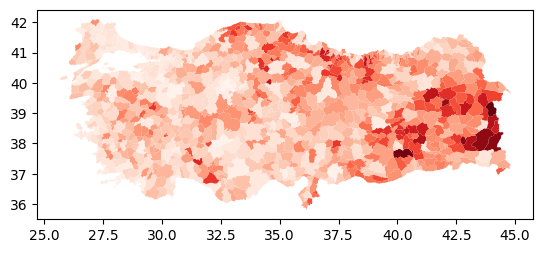

In [41]:
df.plot(column="Okuma yazma bilen fakat bir okul bitirmeyen",cmap="Reds")

<Axes: >

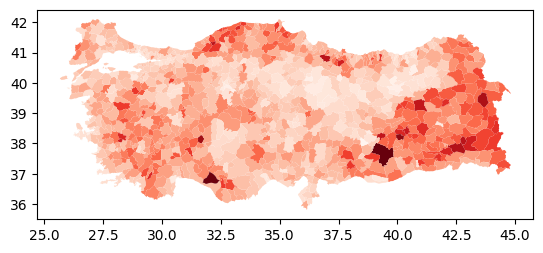

In [42]:
df.plot(column="invalid vote",cmap="Reds")

In [43]:
df["invalid_vote_ratio"]= df["Okuma yazma bilen fakat bir okul bitirmeyen"]/df["invalid vote"]

<Axes: >

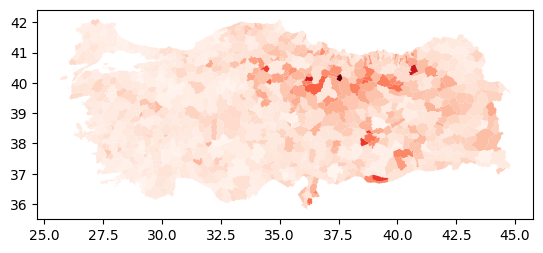

In [44]:
df.plot(column="invalid_vote_ratio",cmap="Reds")

### Apply Isolation Forest

In [45]:
X= df.loc[:,["invalid vote","Okuma yazma bilen fakat bir okul bitirmeyen"]]
X

,,invalid vote,Okuma yazma bilen fakat bir okul bitirmeyen
province,district,,
Kilis,Elbeyli,0.020023,0.047264
Çorum,Dodurga,0.047619,0.078231
Eskişehir,Mahmudiye,0.042998,0.046994
Konya,Tuzlukçu,0.039643,0.080889
Aksaray,Sarıyahşi,0.046694,0.107957
...,...,...,...
Kastamonu,İnebolu,0.039965,0.064233
İstanbul,Şile,0.023791,0.023287
Adana,Seyhan,0.026598,0.012570


<Axes: >

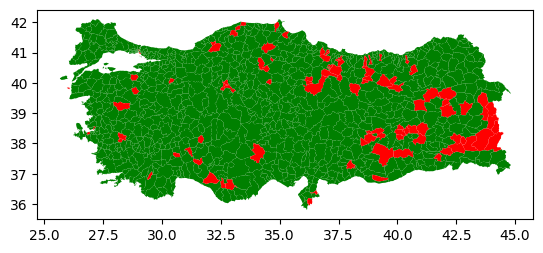

In [46]:
from sklearn.ensemble import IsolationForest
from matplotlib.colors import ListedColormap

iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['anomaly'] = iso_forest.fit_predict(X)
# Anomalies are indicated with -1
anomalies = df[df['anomaly'] == -1]
normal = df[df['anomaly'] != -1]

cmap = ListedColormap(['red', 'green'])  # Red for -1, Green for 1

df.plot(column="anomaly",cmap=cmap)

In [47]:
X= X.copy()
X=X.reset_index()
X.set_index("district")
X.head()

,province,district,invalid vote,Okuma yazma bilen fakat bir okul bitirmeyen
0,Kilis,Elbeyli,0.020023,0.047264
1,Çorum,Dodurga,0.047619,0.078231
2,Eskişehir,Mahmudiye,0.042998,0.046994
3,Konya,Tuzlukçu,0.039643,0.080889
4,Aksaray,Sarıyahşi,0.046694,0.107957


<Axes: >

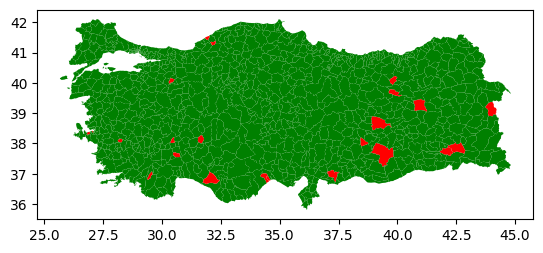

In [57]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
clf = LocalOutlierFactor(n_neighbors=10)
df["anomaly"]=clf.fit_predict(X.loc[:,["Okuma yazma bilen fakat bir okul bitirmeyen","invalid vote"]])
df.plot(column="anomaly",cmap=cmap)

In [119]:
from sklearn.preprocessing import MinMaxScaler
X_scaled= X.copy()
scaler = MinMaxScaler()
X_scaled.loc[:,["invalid vote","Okuma yazma bilen fakat bir okul bitirmeyen"]] = scaler.fit_transform(X.loc[:,["invalid vote","Okuma yazma bilen fakat bir okul bitirmeyen"]]  )

In [58]:
import matplotlib.pyplot as plt
os.environ["OMP_NUM_THREADS"] = '4'
from sklearn.cluster import KMeans
n_clusters=7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X.loc[:,["Okuma yazma bilen fakat bir okul bitirmeyen","invalid vote"]])
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

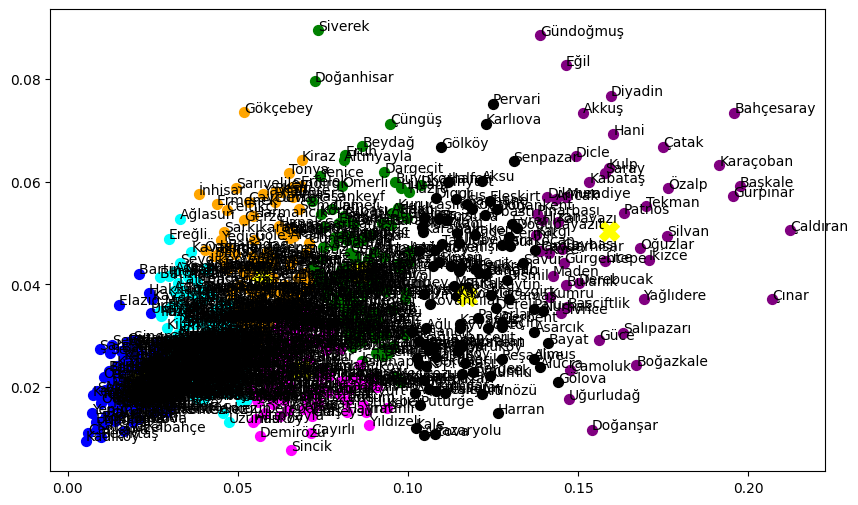

In [59]:
selected_column= "Okuma yazma bilen fakat bir okul bitirmeyen"
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["blue","green","orange","purple","black","magenta","cyan","black","purple","yellow"]
for i in range(n_clusters):
    res = X[labels == i]  
    for idx in res.index:
        ax.scatter(res.loc[idx,selected_column], res.loc[idx,"invalid vote"], s=50,color=colors[i]  , label=f'Cluster {i+1}')
       # if (X.loc[idx,"new_col"]/ X.loc[idx,"invalid vote"])<2:
        ax.annotate(res.loc[idx,"district"], (res.loc[idx,selected_column],  res.loc[idx,"invalid vote"]))
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, color='yellow', marker='X', label='Centroids')
  

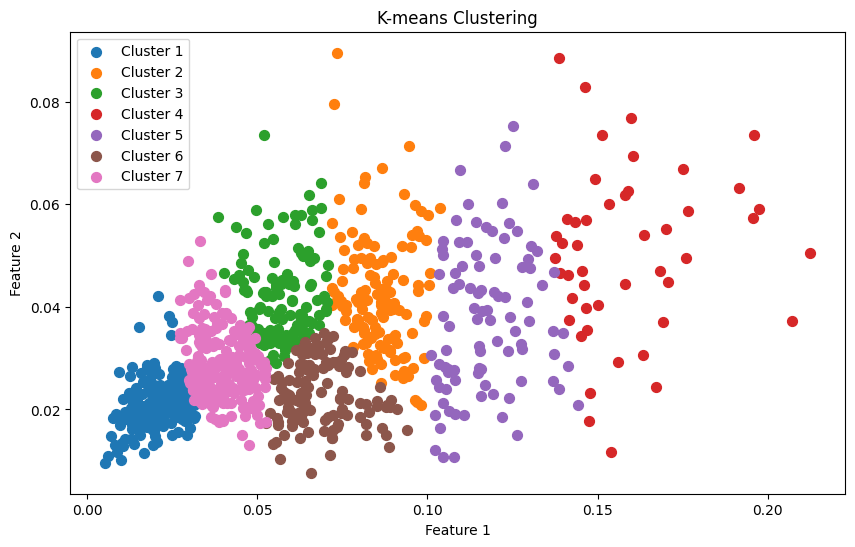

In [60]:
colors = ["blue","green","orange","purple","black","magenta","cyan","purple","yellow","aquamarine","mediumseagreen","gray","tomato","gold","pink","chartreuse","peru","darkviolet",
         "darkkhaki","teal","lightgray","skyblue","lightsalmon"]
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    res = X[labels == i]  
    plt.scatter(res.loc[:, selected_column],res.loc[:, "invalid vote"], s=50, label=f'Cluster {i+1}')
    

#plt.scatter(centroids[:, 0], centroids[:, 1], s=200, color='yellow', marker='X', label='Centroids')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [61]:
len(colors)

23

In [62]:
from sklearn.cluster import DBSCAN
import numpy as np
clustering = DBSCAN(eps=.01, min_samples=1,leaf_size=256).fit(X.loc[:,[selected_column,"invalid vote"]])
labels=clustering.labels_
X["labels"]=labels
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [63]:
n_clusters=len(set(labels))
unique_labels_list = list(set(labels))

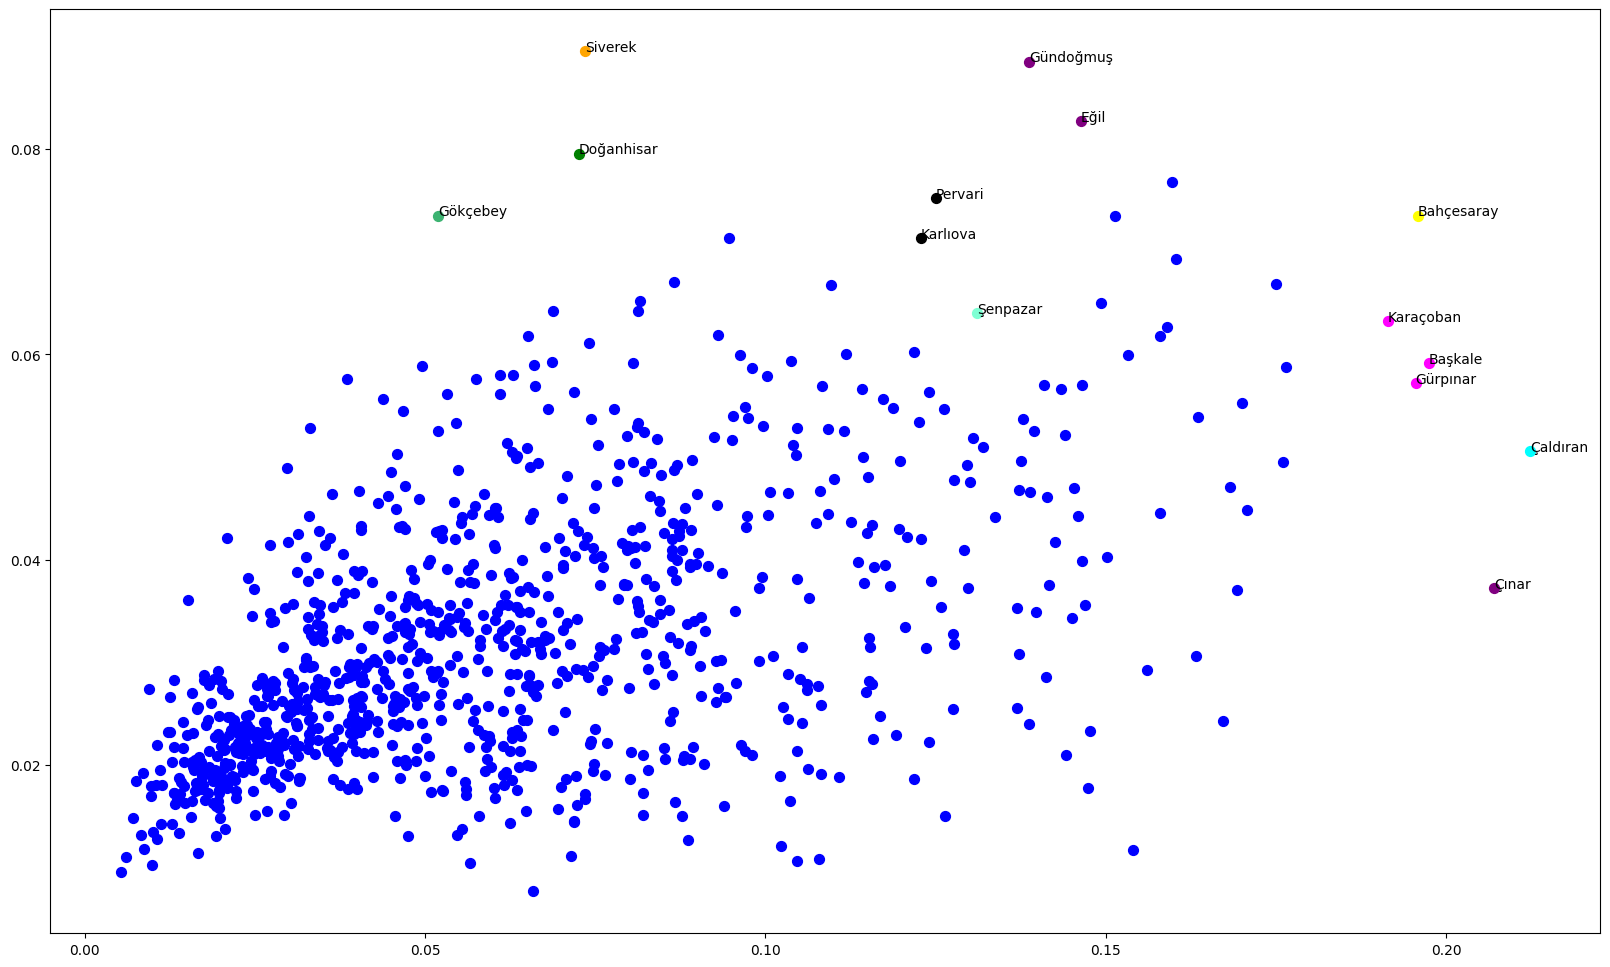

In [64]:
fig, ax = plt.subplots(figsize=(20, 12))
for i,label in enumerate(unique_labels_list):
    res = X[labels == label]  
    for idx in res.index:
        ax.scatter(res.loc[idx,selected_column], res.loc[idx,"invalid vote"], s=50,color=colors[i]  , label=f'Cluster {i+1}')
       # if (X.loc[idx,"new_col"]/ X.loc[idx,"invalid vote"])<2:
        if i>0:
            ax.annotate(res.loc[idx,"district"], (res.loc[idx,selected_column],  res.loc[idx,"invalid vote"]))
#plt.scatter(centroids[:, 0], centroids[:, 1], s=200, color='yellow', marker='X', label='Centroids')
  

In [71]:
# Fit linear regression model
from sklearn.linear_model import LinearRegression

data=X
model = LinearRegression()
model.fit(data[['Okuma yazma bilen fakat bir okul bitirmeyen']], data['invalid vote'])

# Predict y values
data['y_pred'] = model.predict(data[['Okuma yazma bilen fakat bir okul bitirmeyen']])
# Calculate residuals
data['residuals'] = data['invalid vote'] - data['y_pred']
# Define a threshold for outliers (e.g., 2 standard deviations from the mean)
threshold = 2 * data['residuals'].std()

# Identify outliers
data["outliers"] = np.abs(data['residuals'] )> threshold
data['up_outliers'] = data['residuals'] > threshold
data['down_outliers'] = data['residuals'] < -threshold
# Separate outliers and inliers
down_outliers = data[data['down_outliers']]
up_outliers = data[data['up_outliers']]
inliers = data[~data['outliers']]

# Print outliers
print("Outliers detected:")
print(sum(data["outliers"]))

Outliers detected:
53


In [72]:
data

,province,district,invalid vote,Okuma yazma bilen fakat bir okul bitirmeyen,labels,y_pred,residuals,up_outlier,down_outlier,up_outliers,down_outliers,outliers
0,Kilis,Elbeyli,0.020023,0.047264,0,0.029301,-0.009278,False,False,False,False,False
1,Çorum,Dodurga,0.047619,0.078231,0,0.034964,0.012655,False,False,False,False,False
2,Eskişehir,Mahmudiye,0.042998,0.046994,0,0.029252,0.013747,False,False,False,False,False
3,Konya,Tuzlukçu,0.039643,0.080889,0,0.035450,0.004193,False,False,False,False,False
4,Aksaray,Sarıyahşi,0.046694,0.107957,0,0.040399,0.006295,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
968,Kastamonu,İnebolu,0.039965,0.064233,0,0.032404,0.007561,False,False,False,False,False
969,İstanbul,Şile,0.023791,0.023287,0,0.024917,-0.001126,False,False,False,False,False
970,Adana,Seyhan,0.026598,0.012570,0,0.022958,0.003641,False,False,False,False,False
971,Afyonkarahisar,Çobanlar,0.025713,0.045363,0,0.028954,-0.003241,False,False,False,False,False


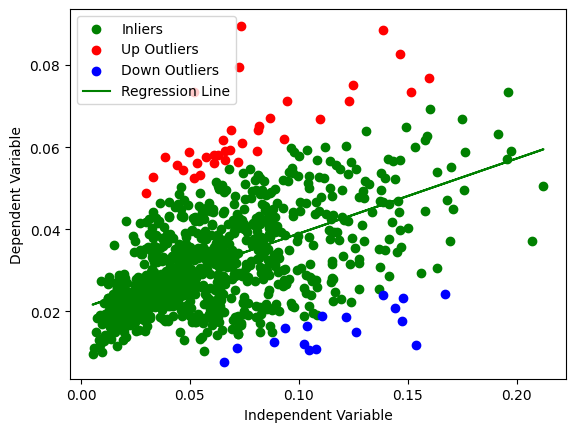

In [74]:
# Plot the data and regression line
plt.scatter(inliers[selected_column], inliers['invalid vote'], label='Inliers', color='green')
plt.scatter(up_outliers[selected_column], up_outliers['invalid vote'], label='Up Outliers', color='red')
plt.scatter(down_outliers[selected_column], down_outliers['invalid vote'], label='Down Outliers', color='blue')

plt.plot(data[selected_column], data['y_pred'], label='Regression Line', color='green')
plt.xlabel('Independent Variable')
plt.ylabel('Dependent Variable')
plt.legend()
plt.show()

# ANALYSIS

In [75]:
df_edu.head(5)

Okuma yazma bilmeyen  \
province district                          
Adana    Aladağ                      684   
         Ceyhan                     2159   
         Feke                        502   
         Karaisalı                  1202   
         Karataş                     683   

                    Okuma yazma bilen fakat bir okul bitirmeyen  İlkokul  \
province district                                                          
Adana    Aladağ                                             693     2411   
         Ceyhan                                            4688     4892   
         Feke                                               994     3673   
         Karaisalı                                          763     5266   
         Karataş                                            744     4652   

                    İlköğretim  Ortaokul veya dengi okul  \
province district                                          
Adana    Aladağ           1813                      1965   
         Ceyhan           8339                     11053   
         Feke             1552                      1932   
         Karaisalı        1770                      2346   
         Karataş          1484                      2833   

                    Lise veya dengi okul  Yüksekokul veya fakülte  \
province district                                                   
Adana    Aladağ                     3297                     1324   
         Ceyhan                     2732                     5985   
         Feke                       2761                     1184   
         Karaisalı                  3849                     1914   
         Karataş                    4415                     1836   

                    Yüksek lisans  Doktora  Bilinmeyen  Toplam  
province district                                               
Adana    Aladağ               105        9          29   12330  
         Ceyhan              1345       72         750     103  
         Feke                  82       14          94   12788  
         Karaisalı            149        7          46   14908  
         Karataş              166       10         209   14727

In [77]:
df_edu = df_edu.groupby(["province","district"]).sum()

In [78]:
df_edu.head()

Okuma yazma bilmeyen  \
province district                          
Adana    Aladağ                      684   
         Ceyhan                     2159   
         Feke                        502   
         Karaisalı                  1202   
         Karataş                     683   

                    Okuma yazma bilen fakat bir okul bitirmeyen  İlkokul  \
province district                                                          
Adana    Aladağ                                             693     2411   
         Ceyhan                                            4688     4892   
         Feke                                               994     3673   
         Karaisalı                                          763     5266   
         Karataş                                            744     4652   

                    İlköğretim  Ortaokul veya dengi okul  \
province district                                          
Adana    Aladağ           1813                      1965   
         Ceyhan           8339                     11053   
         Feke             1552                      1932   
         Karaisalı        1770                      2346   
         Karataş          1484                      2833   

                    Lise veya dengi okul  Yüksekokul veya fakülte  \
province district                                                   
Adana    Aladağ                     3297                     1324   
         Ceyhan                     2732                     5985   
         Feke                       2761                     1184   
         Karaisalı                  3849                     1914   
         Karataş                    4415                     1836   

                    Yüksek lisans  Doktora  Bilinmeyen  Toplam  
province district                                               
Adana    Aladağ               105        9          29   12330  
         Ceyhan              1345       72         750     103  
         Feke                  82       14          94   12788  
         Karaisalı            149        7          46   14908  
         Karataş              166       10         209   14727

In [80]:
df_edu["0.seviye"] = df_edu[df_edu.columns[:5]].sum(axis=1) # ortaokul öncesi
df_edu["1.seviye"] = df_edu[df_edu.columns[[5]]].sum(axis=1) # ortaokul
df_edu["2.seviye"]= df_edu[df_edu.columns[6:9]].sum(axis=1) # lise ve üstü
df_edu.drop(columns=df_edu.columns[:9],inplace=True)
df_edu.head()

IndexError: index 5 is out of bounds for axis 0 with size 5

In [81]:
df_election.head()

Oy kullanan seçmen sayısı  Geçerli oy sayısı  invalid vote
province district                                                             
Adana    Seyhan                        489246             476233         13013
         Ceyhan                         98825              95960          2865
         Feke                           11039              10590           449
         Karaisalı                      16011              15573           438
         Karataş                        15307              14995           312

In [82]:
# Symettric difference of two sets of indices must be empty for consistency
set(df_election.index.unique()).symmetric_difference(set(df_edu.index.unique()))

set()

In [83]:
df = pd.merge(df_edu, df_election, left_index=True, right_index=True)
df.head()

Bilinmeyen  Toplam  0.seviye  1.seviye  2.seviye  \
province district                                                      
Adana    Aladağ             29   12330     24660      3297      1438   
         Ceyhan            750     103     42118      2732      7402   
         Feke               94   12788     25576      2761      1280   
         Karaisalı          46   14908     32220      3849      2070   
         Karataş           209   14727     31759      4415      2012   

                    Oy kullanan seçmen sayısı  Geçerli oy sayısı  invalid vote  
province district                                                               
Adana    Aladağ                         11220              10810           410  
         Ceyhan                         98825              95960          2865  
         Feke                           11039              10590           449  
         Karaisalı                      16011              15573           438  
         Karataş                        15307              14995           312

In [84]:
df.corr()["Okuma yazma bilmeyen"].sort_values(ascending=False)

KeyError: 'Okuma yazma bilmeyen'

In [ ]:
df.corr()["Yüksek lisans"].sort_values(ascending=False)

In [85]:
df.corr()["1.seviye"].sort_values(ascending=False)

1.seviye                     1.000000
0.seviye                     0.718801
2.seviye                     0.536994
invalid vote                 0.046665
Oy kullanan seçmen sayısı   -0.011829
Geçerli oy sayısı           -0.013149
Bilinmeyen                  -0.020911
Toplam                      -0.191925
Name: 1.seviye, dtype: float64

In [ ]:
df.corr()["2.seviye"].sort_values(ascending=False)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
from sklearn.preprocessing import StandardScaler

ss = MinMaxScaler()
df_edu_scaled = pd.DataFrame(ss.fit_transform(df_edu),columns = df_edu.columns)
df_edu_scaled.head()

In [ ]:
def fun(x):
    return x/sum(x)
df_election_scaled = df_election.apply(fun, axis=1)#.sum(axis=1)  uncomment to check that sums up to 1 
df_edu_scaled = df_edu.apply(fun, axis=1)#.sum(axis=1)  uncomment to check that sums up to 1 

In [ ]:
df_scaled = pd.merge(df_edu_scaled, df_election_scaled, left_index=True, right_index=True)
df_scaled.head()

In [ ]:
df.corr()["0.seviye"].sort_values(ascending=False),df_scaled.corr()["0.seviye"].sort_values(ascending=False)

In [ ]:
df.corr()["1.seviye"].sort_values(ascending=False),df_scaled.corr()["1.seviye"].sort_values(ascending=False)